# Welcome to TXPipe

Kernel: desc-python <br>
Owner: E Phillips Longley, Slack: Emily Phillips Longley, github: ellongley <br> 
Last Verified: 11/14/2019 <br>


TXPipe is a pipeline to perform 3x2 pt analysis on DC2 products.   3x2 pt. refers to the combined analysis of galaxy clustering and weak lensing, and involves the computation of three 2pt. functions, the autocorrelation of galaxy shapes (Shear-Shear) the autocorrelation of galaxy positions (Position-Position) and the cross-correlation of lens galaxy positions and source galaxy shapes (Shear-Position).

This notebook serves to walk through the stages of the pipeline.  The pipeline lives in the TXPipe repo: https://github.com/LSSTDESC/TXPipe.  Each stage of calculation is a python module in this repo.  The pipeline is run as a series of these stages where the outputs of the previous stage are the inputs to the next stage.  This is run through the Parsl workflow system which is described here: https://ceci.readthedocs.io/en/latest/.

In [13]:
import matplotlib
import pandas as pd
import numpy as np
from astropy.io import fits
from astropy.table import Table
import matplotlib.pyplot as plt
import treecorr
import h5py   
from math import *
%matplotlib inline
from scipy import stats

In [2]:
input_data_path = '/global/cscratch1/sd/elp25/TXPipe/data/metacal-2.1i-dr1b-inputs/'

In [14]:
import sys

In [15]:
sys.path.insert(0, '/global/cscratch1/sd/elp25/sacc/')

In [16]:
import sacc

# Input Catalog 

The input data catalog used here is a shear and photometry catalog run on DC2 dr1b Run 2.1i.

### Details about the Model in the Input Catalogs

There is also an option to generate an emulated data catalog. 


This catalog is simulated in the metacal format, to learn more about metacalibration see this paper: 

https://arxiv.org/pdf/1702.02600.pdf

Metacalibration calibrates shear biases by measuring the response of an object to a shear.  In this catalog these shear responses are simulated based on the DES Year One Model.

R(log10(snr), size) <br>
R_std(log10(snr), size) <br>
where R is the mean metacal response in a bin and <br>
R_std is its standard deviation. 

To see more about this implementation see https://arxiv.org/pdf/1708.01533.pdf. 

In [17]:
from astropy.coordinates import SkyCoord
import FoFCatalogMatching
import GCRCatalogs
from GCR import GCRQuery

### Load the Catalogs

In [18]:
shear_catalog_file = input_data_path + 'shear_catalog.hdf5'

In [19]:
photometry_catalog_file = input_data_path + 'photometry_catalog.hdf5'

In [20]:
photo_file =  h5py.File(photometry_catalog_file, 'r')
photo_data = photo_file['photometry']

In [21]:
shear_file =  h5py.File(shear_catalog_file, 'r')
shear_data = shear_file['metacal']

In [22]:
#Note the catalogs are in the metacal format "mcal_T_1m" for example refers to the value of T remeasured on an object 
# that has had a negaive applied shear
cols = [col for col in shear_data]
print(cols[0:5])

['dec', 'id', 'mcal_T', 'mcal_T_1m', 'mcal_T_1p']


# TXPhotozPDF

This stage creates photo-z PDF estimates for each object.  The photo-z code that is currently linked to the pipeline is the MLZ code, Machine Learning for photo-Z. https://github.com/mgckind/MLZ This code uses a random forest algorithm to create photo-z estimates.  

In [23]:
path = '/global/cscratch1/sd/elp25/TXPipe/outputs/'

In [24]:
stacked_photozs =  h5py.File(path + 'photoz_stack.hdf5', 'r')

In [25]:
for group in stacked_photozs:
    print(group)

n_of_z


In [26]:
for member in stacked_photozs['n_of_z']:
    print(member)

lens
source


In [27]:
for item in stacked_photozs['n_of_z/lens']:
    print(item)

bin_0
z


We can plot the stacked pdfs to look at the n(z)'s per bin.  Currently these are computed by naively stacking photo-z PDFs in bins however, plans are to change this stage to use CHIPPR which is a method for computing these probabalistically.  https://github.com/aimalz/chippr

### N(z)'s

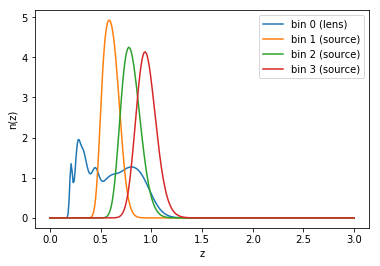

In [28]:
for bin_num in ['0','1','2','3']:
    if bin_num=='0':
        plt.plot(stacked_photozs['n_of_z/lens']['z'],stacked_photozs['n_of_z/lens']['bin_'+bin_num],label='bin '+ bin_num + ' (lens)')
    else:
        plt.plot(stacked_photozs['n_of_z/source']['z'],stacked_photozs['n_of_z/source']['bin_'+bin_num],label='bin '+ bin_num + ' (source)')
plt.legend(loc='best')
plt.ylabel('n(z)')
plt.xlabel('z')
plt.show()

# TXSelector

This pipeline stage selects objects to be used as the source sample for the shear-shear and shear-position calibrations.  It applies some general cuts based on the flags that metacal gives for the objects, and size and S/N cuts
based on the configuration file.  It also splits those objects into tomographic bins according to the choice the user makes in the input file, from the information in the photo-z PDF file.  Once these selections are made it constructs
the quantities needed to calibrate each bin, this consists of two shear response quantities.

Lens selection is done in this stage based on a series of magnitude and color cuts from SDSS: http://www.sdss3.org/dr9/algorithms/boss_galaxy_ts.php

However, this will eventually be linked to RedMagic code.

# TXDiagnosticMaps

This stage computes a depth map using the DR1 method, which takes the mean magnitude of objects close to 5-sigma S/N.  In the future we will add the calculation of other diagnostic maps like airmass for use in systematics tests and covariance mode projection.

In [29]:
import pandas as pd
import numpy as np
import healpy as hp

In [30]:
maps = h5py.File(path + "diagnostic_maps.hdf5",'r')

### Depth Map

In [37]:
import healpy
import numpy as np
group = '/maps'
nside = 1024
npix = healpy.nside2npix(nside)
m = np.repeat(healpy.UNSEEN, npix)
pix = maps['maps']['depth']['pixel'][:]
val = maps['maps']['depth']['value'][:]
m[pix] = val

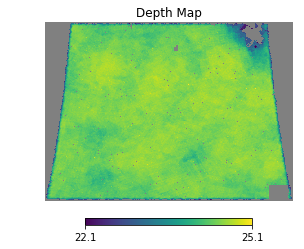

In [38]:
lon,lat=healpy.pix2ang(nside,pix,lonlat=True)
npix=healpy.nside2npix(nside)
if len(pix)==0:
    print(f"Empty map {map_name}")
if len(pix)==len(m):
    w = np.where((m!=healpy.UNSEEN)&(m!=0))
else:
    w = None
lon_range = [lon[w].min()-0.1, lon[w].max()+0.1]
lat_range = [lat[w].min()-0.1, lat[w].max()+0.1]
m[m==0] = healpy.UNSEEN
title = 'Depth Map'
view = 'cart'
if view == 'cart':
    healpy.cartview(m, lonra=lon_range, latra=lat_range, title=title, hold=True)#, **kwargs)
elif view == 'moll':
    healpy.mollview(m, title=title, hold=True)#, **kwargs)

### Shear Map

In [39]:
group = '/maps'
nside = 1024
npix = healpy.nside2npix(nside)
m = np.repeat(healpy.UNSEEN, npix)
pix = maps['maps']['g1_1']['pixel'][:]
val = maps['maps']['g1_1']['value'][:]
m[pix] = val

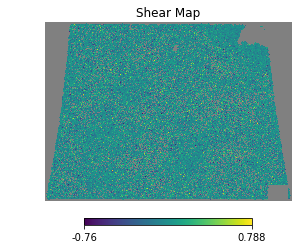

In [40]:
lon,lat=healpy.pix2ang(nside,pix,lonlat=True)
npix=healpy.nside2npix(nside)
if len(pix)==0:
    print(f"Empty map {map_name}")
if len(pix)==len(m):
    w = np.where((m!=healpy.UNSEEN)&(m!=0))
else:
    w = None
lon_range = [lon[w].min()-0.1, lon[w].max()+0.1]
lat_range = [lat[w].min()-0.1, lat[w].max()+0.1]
m[m==0] = healpy.UNSEEN
title = 'Shear Map'
view = 'cart'
if view == 'cart':
    healpy.cartview(m, lonra=lon_range, latra=lat_range, title=title, hold=True)#, **kwargs)
elif view == 'moll':
    healpy.mollview(m, title=title, hold=True)#, **kwargs)

# TXRandoms

This stage creates a randoms catalog for use in the twopoint calculation.

In [41]:
# Randoms data

randoms = h5py.File(path + "random_cats.hdf5",'r')

ra = randoms['randoms/ra'][:]
dec = randoms['randoms/dec'][:]
ra[ra>180] -= 360

In [42]:
H, xedges, yedges = np.histogram2d(ra, dec,bins=200)

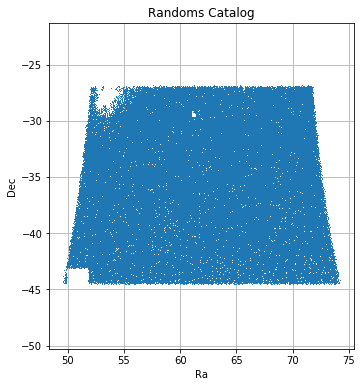

In [43]:
plt.figure(figsize=(12,6))
plt.subplot(122)
plt.plot(ra[::100], dec[::100], ',')
plt.axis('equal')
plt.xlabel("Ra")
plt.ylabel("Dec")
plt.title("Randoms Catalog")
plt.grid()

# TXCov

This stage computes a Gaussian covariance matrix in fourier space.  This is based on the formula in takada and jain 2005: https://arxiv.org/pdf/astro-ph/0310125.pdf (equation 14 is the relevant equation).

In [44]:
# Note one todo for this is to save the covariance output alongside the data vector and n(z) in the SACC output.
#cov_path = 'TXPipe/outputs'

In [45]:
#cov_matrix = np.load(cov_path+'cov_test.npy')

In [46]:
plt.figure(figsize=(7,7))
plt.imshow(cov_matrix,vmin=0.0,vmax=1e-20)
plt.colorbar()
plt.title('Gaussian Covariance Matrix Fourier Space')

NameError: name 'cov_matrix' is not defined

<Figure size 504x504 with 0 Axes>

# TXTwoPoint

## Output File

Sample output from the pipeline.

In [49]:
twopoint_data = sacc.Sacc.load_fits(path+'twopoint_data.sacc')

In [65]:
!ls /global/projecta/projectdirs/lsst/groups/WL/users/zuntz/data/2.1i-inputs

cosmoDC2_trees_i25.3.npy  sample_cosmodc2_w10year_errors.dat  star_catalog.hdf5
photometry_catalog.hdf5   shear_catalog.hdf5


## Clustering Correlation Function

In [183]:
c_data = twopoint_data.get_theta_xi('galaxy_density_xi', 'lens_0', 'lens_0')

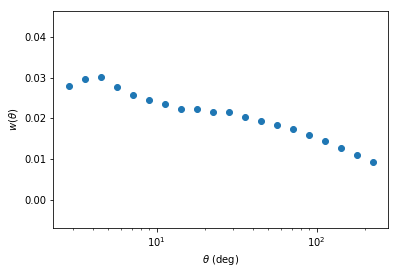

In [188]:
plt.scatter(c_data[0],c_data[1])
plt.xscale('log')
plt.ylabel(r'$w(\theta)$')
plt.xlabel(r'$\theta$ (deg)')
plt.xlabel(r'$\theta$ (deg)')
plt.show()

## Galaxy-Galaxy Lensing Function

In [195]:
gg_data = twopoint_data.get_theta_xi('galaxy_shearDensity_xi_t', 'source_1', 'lens_0')

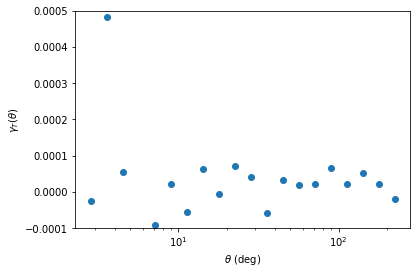

In [197]:
plt.scatter(gg_data[0],gg_data[1])
plt.ylim(-1e-4,5e-4)
plt.xscale('log')
plt.ylabel(r'$\gamma_T(\theta)$')
plt.xlabel(r'$\theta$ (deg)')
plt.xlabel(r'$\theta$ (deg)')
plt.show()

## Cosmic Shear Correlation Function

In [166]:
shear_data = twopoint_data.get_theta_xi('galaxy_shear_xi_plus', 'source_1', 'source_1')

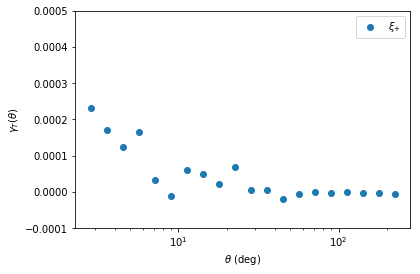

In [167]:
plt.scatter(shear_data[0],shear_data[1],label=r'$\xi_{+}$')
plt.ylim(-1e-4,5e-4)
plt.ylabel(r'$\chi_+$($\theta$)')
plt.xlabel(r'$\theta$ (deg)')
plt.xscale('log')
plt.xlabel(r'$\theta$ (deg)')
plt.ylabel(r'$\gamma_T(\theta)$')
plt.legend(loc='best')
plt.show()

In [168]:
shear_data = twopoint_data.get_theta_xi('galaxy_shear_xi_minus', 'source_1', 'source_1')

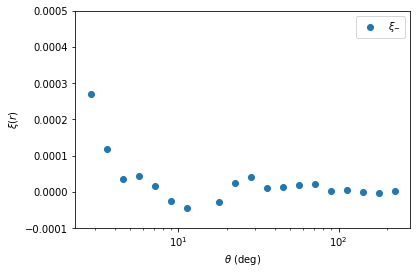

In [169]:
plt.scatter(shear_data[0],shear_data[1],label=r'$\xi_{-}$')
plt.ylim(-1e-4,5e-4)
plt.ylabel(r'$\chi_+$($\theta$)')
plt.xlabel(r'$\theta$ (deg)')
plt.xscale('log')
plt.xlabel(r'$\theta$ (deg)')
plt.ylabel(r'$\xi (r)$')
plt.legend(loc='best')
plt.show()